In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import platform
import random
import uuid
import os
import os.path
import skimage
import utils
import utils.wavelet
import utils.data
import utils.data.augmentation
import numpy as np
import scipy as sp
import scipy.signal
import pandas as pd
import networkx
import networkx.algorithms.approximation
import math
import wfdb
import json
import tqdm
import matplotlib.pyplot as plt
import src.data
from scipy.stats import norm
from utils.signal import StandardHeader
from scipy.stats import lognorm, norm, halfnorm

from src.data import trailonset

# Load files

In [3]:
P = utils.pickleload(os.path.join('.','pickle','Psignal.pkl'))
PQ = utils.pickleload(os.path.join('.','pickle','PQsignal.pkl'))
QRS = utils.pickleload(os.path.join('.','pickle','QRSsignal.pkl'))
ST = utils.pickleload(os.path.join('.','pickle','STsignal.pkl'))
T = utils.pickleload(os.path.join('.','pickle','Tsignal.pkl'))
TP = utils.pickleload(os.path.join('.','pickle','TPsignal.pkl'))

In [4]:
for key in (['104_II','104_III','104_AVR','104_AVF','103_III'] + 
            ['74_{}'.format(h) for h in StandardHeader] + 
            ['111_{}'.format(h) for h in StandardHeader] +
            ['95_{}'.format(h) for h in StandardHeader] + 
            ['103_{}'.format(h) for h in StandardHeader] +
            ['34_{}'.format(h) for h in StandardHeader]):
    [P.pop(k) for k in list(P.keys()) if k.startswith('{}###'.format(key))]
    [PQ.pop(k) for k in list(PQ.keys()) if k.startswith('{}###'.format(key))]
    [QRS.pop(k) for k in list(QRS.keys()) if k.startswith('{}###'.format(key))]
    [ST.pop(k) for k in list(ST.keys()) if k.startswith('{}###'.format(key))]
    [T.pop(k) for k in list(T.keys()) if k.startswith('{}###'.format(key))]
    [TP.pop(k) for k in list(TP.keys()) if k.startswith('{}###'.format(key))]

In [5]:
for key in []: 
    if key in P: P.pop(key)
for key in []: 
    if key in PQ: PQ.pop(key)
for key in ['7_V2###0','7_V2###2','7_V2###4','95_V4###0','95_V4###1','95_V4###2']: 
    if key in QRS: QRS.pop(key)
for key in []: 
    if key in ST: ST.pop(key)
for key in []: 
    if key in T: T.pop(key)
for key in (['52_III###4','34_V6###6','74_V4###0','74_V4###1','74_V4###2',
             '74_V4###3','74_V4###4','74_V4###5','74_V4###6','74_V4###7',] + 
            ['111_V2###{}'.format(i) for i in range(7)]): 
    if key in TP: TP.pop(key)

# Normalize amplitudes

In [6]:
metric = np.max

amplitudes = {k.split('###')[0]: [] for k in list(QRS)}
for k in QRS:
    g = k.split('###')[0]
    segment = utils.signal.on_off_correction(QRS[k])
    amplitudes[g].append(np.max(segment) - np.min(segment))

In [7]:
Pamplitudes = []
for k in P:
    segment = utils.signal.on_off_correction(P[k])/metric(amplitudes[k.split('###')[0]])
    Pamplitudes.append(segment.max()-segment.min())
Pamplitudes = np.array(Pamplitudes)
PQamplitudes = []
for k in PQ:
    segment = utils.signal.on_off_correction(PQ[k])/metric(amplitudes[k.split('###')[0]])
    PQamplitudes.append(segment.max()-segment.min())
PQamplitudes = np.array(PQamplitudes)
QRSamplitudes = []
for k in QRS:
    segment = utils.signal.on_off_correction(QRS[k])/metric(amplitudes[k.split('###')[0]])
    QRSamplitudes.append(segment.max()-segment.min())
QRSamplitudes = np.array(QRSamplitudes)
STamplitudes = []
for k in ST:
    segment = utils.signal.on_off_correction(ST[k])/metric(amplitudes[k.split('###')[0]])
    STamplitudes.append(segment.max()-segment.min())
STamplitudes = np.array(STamplitudes)
Tamplitudes = []
for k in T:
    segment = utils.signal.on_off_correction(T[k])/metric(amplitudes[k.split('###')[0]])
    Tamplitudes.append(segment.max()-segment.min())
Tamplitudes = np.array(Tamplitudes)
TPamplitudes = []
for k in TP:
    segment = utils.signal.on_off_correction(TP[k])/metric(amplitudes[k.split('###')[0]])
    TPamplitudes.append(segment.max()-segment.min())
TPamplitudes = np.array(TPamplitudes)

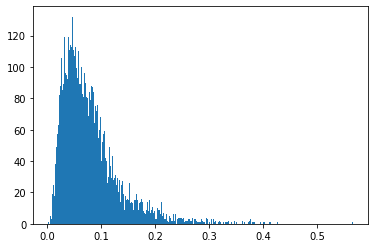

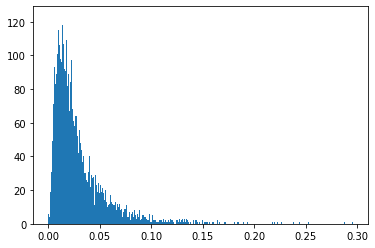

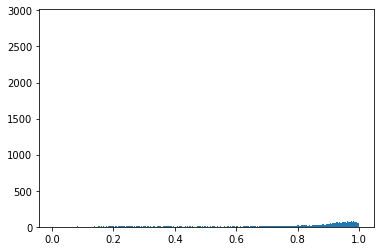

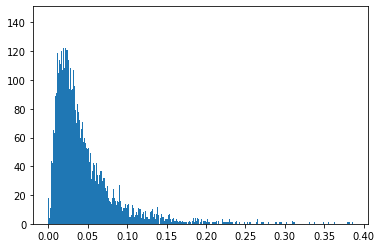

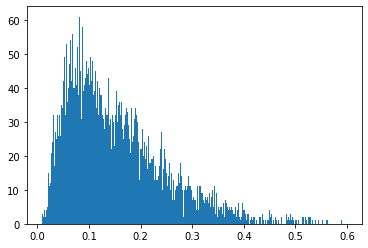

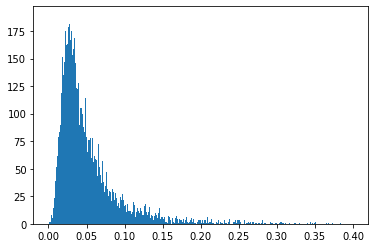

In [8]:
plt.figure()
_ = plt.hist(Pamplitudes,bins=1000)
plt.savefig('./Pamplitudes.svg')
plt.figure()
_ = plt.hist(PQamplitudes[PQamplitudes<0.3],bins=1000)
plt.savefig('./PQamplitudes.svg')
plt.figure()
_ = plt.hist(QRSamplitudes,bins=1000)
plt.savefig('./QRSamplitudes.svg')
plt.figure()
_ = plt.hist(STamplitudes[STamplitudes<0.4],bins=1000)
plt.savefig('./STamplitudes.svg')
plt.figure()
_ = plt.hist(Tamplitudes[Tamplitudes<0.6],bins=1000)
plt.savefig('./Tamplitudes.svg')
plt.figure()
_ = plt.hist(TPamplitudes[TPamplitudes<0.4],bins=1000)
plt.savefig('./TPamplitudes.svg')

In [9]:
# [Pamplitudes,2*Pamplitudes]

In [10]:
Pamplitudes = scipy.stats.lognorm(*scipy.stats.lognorm.fit(Pamplitudes/2))
PQamplitudes = scipy.stats.lognorm(*scipy.stats.lognorm.fit(PQamplitudes[PQamplitudes<0.3]))
QRSamplitudes = scipy.stats.lognorm(*scipy.stats.lognorm.fit(QRSamplitudes))
STamplitudes = scipy.stats.lognorm(*scipy.stats.lognorm.fit(STamplitudes))
Tamplitudes = scipy.stats.lognorm(*scipy.stats.lognorm.fit(Tamplitudes[(Tamplitudes>0.05) & (Tamplitudes<0.5)]))
TPamplitudes = scipy.stats.lognorm(*scipy.stats.lognorm.fit(TPamplitudes[TPamplitudes<0.4]))

In [11]:
for k in list(P.keys()):
    segment = utils.signal.on_off_correction(P[k])
    P[k] = segment/(np.max(segment)-np.min(segment))
    if np.any(np.isinf(P[k])) or np.any(np.isnan(P[k])):
        P.pop(k)
for k in list(PQ.keys()):
    segment = utils.signal.on_off_correction(PQ[k])
    PQ[k] = segment/(np.max(segment)-np.min(segment))
    if np.any(np.isinf(PQ[k])) or np.any(np.isnan(PQ[k])):
        PQ.pop(k)
for k in list(QRS.keys()):
    segment = utils.signal.on_off_correction(QRS[k])
    QRS[k] = segment/(np.max(segment)-np.min(segment))
    if np.any(np.isinf(QRS[k])) or np.any(np.isnan(QRS[k])):
        QRS.pop(k)
for k in list(ST.keys()):
    segment = utils.signal.on_off_correction(ST[k])
    ST[k] = segment/(np.max(segment)-np.min(segment))
    if np.any(np.isinf(ST[k])) or np.any(np.isnan(ST[k])):
        ST.pop(k)
for k in list(T.keys()):
    segment = utils.signal.on_off_correction(T[k])
    T[k] = segment/(np.max(segment)-np.min(segment))
    if np.any(np.isinf(T[k])) or np.any(np.isnan(T[k])):
        T.pop(k)
for k in list(TP.keys()):
    segment = utils.signal.on_off_correction(TP[k])
    TP[k] = segment/(np.max(segment)-np.min(segment))
    if np.any(np.isinf(TP[k])) or np.any(np.isnan(TP[k])):
        TP.pop(k)

<ipython-input-11-0e724456727d>:8: RuntimeWarning: invalid value encountered in true_divide
  PQ[k] = segment/(np.max(segment)-np.min(segment))
<ipython-input-11-0e724456727d>:18: RuntimeWarning: invalid value encountered in true_divide
  ST[k] = segment/(np.max(segment)-np.min(segment))


# AFib

#### Method 1)

In [12]:
# #hyperparams
# w = 5
# n = np.random.randint(1,4)

# # Segment retrieval
# segment = P[list(P)[np.random.randint(0,len(P))]]

# # AFib simulation
# on = np.random.choice([0,segment.size,2*segment.size])

# segment  = np.concatenate([-segment,segment]*n)/2
# amplcor  = np.ones_like(segment)

# noise = np.linspace(1,np.random.randn(1),segment.size).squeeze()*0.5+0.5
# segment *= noise
# amplcor *= noise

# # noise = np.sin(np.linspace(0,np.random.randint(5,20),segment.size)+np.random.randn(1))*0.4+0.6
# # segment *= noise
# # amplcor *= noise

# # noise = scipy.signal.chirp(np.linspace(0,np.random.randint(5,20),segment.size),0,200,np.random.randint(5,30))*0.4+0.6
# # segment *= noise
# # amplcor *= noise

# noise = np.convolve(np.random.rand(2*segment.size),np.hamming(w)/(w/2),mode='same')[segment.size//2:-segment.size//2]
# segment *= noise
# amplcor *= noise

# segment  = segment[on:]
# amplcor  = amplcor[on:]
# # segment *= np.max(1/amplcor)
# # segment  = segment/(np.max(segment)-np.min(segment))
# # segment = utils.signal.on_off_correction(segment)
# plt.plot(segment)


In [13]:
# x = np.linspace(0,1,np.random.randint(10,100))

# fundamentals = [
# #     lambda x,i: x**i,
# #     lambda x,i: (np.sin(x*np.pi/2))**i,
# #     lambda x,i: (-np.cos(x*np.pi/2)+1)**i,
# #     lambda x,i: -np.exp(-(i+2)*x)+1,
#     lambda x,i: np.random.rand(1)/(1 + np.exp(-np.random.randint(10,20)*(x-0.5))),
#     lambda x,i: x,
# ]

# for f in fundamentals:
#     plt.plot(f(x,np.random.randint(1,5)))

In [14]:
# f = np.random.choice(fundamentals)
# i = np.random.randint(1,10)
# x = np.linspace(0,1,segment.size)

# ix_left = np.random.randint(2,segment.size//4)
# ix_right = np.random.randint(3*segment.size//4,segment.size-1)

# ampl_left = (np.random.rand(1)*0.75+1)
# ampl_right = (np.random.rand(1)*0.75+1)

# x_left = x*ampl_left
# x_right = x*ampl_right-(ampl_right-1)
# x_center = f(np.linspace(0,1,np.random.randint(segment.size//8,ix_right-ix_left)),i)
# # x_center *= np.sin(x_center)
# # x_center
# # x_center = f(np.linspace(0,1,ix_right-ix_left).squeeze(),i)
# x_center = (x_right[ix_right-1]-x_left[ix_left])*x_center/(np.max(x_center)-np.min(x_center))+x_left[ix_left]
# x2 = np.concatenate((x_left[:ix_left],x_center,x_right[ix_right:]))

# print(x.size)
# print(x2.size)

# plt.plot(np.linspace(0,1,x.size),x)
# plt.plot(np.linspace(0,1,x2.size),x2)


In [15]:
# fundamentals = [
# #     lambda x,i: x**i,
# #     lambda x,i: (np.sin(x*np.pi/2))**i,
# #     lambda x,i: (-np.cos(x*np.pi/2)+1)**i,
# #     lambda x,i: -np.exp(-(i+2)*x)+1,
#     lambda x,i: np.random.rand(1)/(1 + np.exp(-np.random.randint(10,20)*(x-0.5))),
#     lambda x,i: x,
# ]

# #hyperparams
# w = 5
# n = np.random.randint(4,8)

# # Segment retrieval
# segment = P[list(P)[np.random.randint(0,len(P))]]
# # skjggl
# # AFib simulation
# on = np.random.choice([0,segment.size,2*segment.size])
# seglist = []
# x = np.linspace(0,1,segment.size)
# for i in range(n):
#     f = np.random.choice(fundamentals)

#     ix_left = np.random.randint(2,segment.size//4)
#     ix_right = np.random.randint(3*segment.size//4,segment.size-1)

#     ampl_left = (np.random.rand(1)*0.75+1)
#     ampl_right = (np.random.rand(1)*0.75+1)

#     x_left = x*ampl_left
#     x_right = x*ampl_right-(ampl_right-1)
#     x_center = np.linspace(x_left[ix_left],x_right[ix_right-1],np.random.randint(segment.size//4,ix_right-ix_left))
# #     x_center = f(np.linspace(0,1,ix_right-ix_left).squeeze(),np.random.randint(1,10))
# #     x_center = (x_right[ix_right-1]-x_left[ix_left])*x_center/(np.max(x_center)-np.min(x_center))+x_left[ix_left]
    
#     x2 = np.concatenate((x_left[:ix_left],x_center,x_right[ix_right:]))
    
#     print(x2.size)
#     seglist.append(sp.interpolate.interp1d(x,((-1)**i)*segment)(x2)[:-1])
# # plt.plot(segment)
# segment  = np.concatenate(seglist)
# plt.figure()
# plt.plot(segment)


#### Method 2)

In [16]:
# #hyperparams
# w = 5
# n = np.random.randint(2,8)

# # Segment retrieval
# segment = P[list(P)[np.random.randint(0,len(P))]]

# # AFib simulation
# on = np.random.choice([0,segment.size,2*segment.size])
# seglist = []
# for i in range(n):
#     x = np.linspace(0,1,segment.size)
#     f = np.random.choice(fundamentals)
#     seglist.append(sp.interpolate.interp1d(x,((-1)**i)*segment)(f(x,np.random.randint(1,5))))
# afjsdlkgfj
# plt.plot(segment)
# segment  = np.concatenate(seglist)
# plt.figure()
# plt.plot(segment)


#### Method 3)

In [17]:
# pAF = P[list(P)[np.random.randint(0,len(P))]]
# pAF = sp.interpolate.interp1d(np.linspace(0,1,pAF.size),pAF)(np.linspace(0,1,pAF.size//2))
# i = np.random.choice([0,1])
# segment  = TP[list(TP)[np.random.randint(0,len(TP))]]
# segment  = sp.interpolate.interp1d(np.linspace(0,1,segment.size),segment)(np.linspace(0,1,segment.size+pAF.size))
# segment  = np.convolve(segment,np.concatenate([((-1)**(i))*pAF,((-1)**(i+1))*pAF]))
# segment /= np.max(segment)-np.min(segment)
# segment *= 2*Pamplitudes.rvs(1)

# plt.plot(pAF)
# plt.figure()
# plt.plot(segment)

# Plot src.data.Dataset

In [18]:
tmp = src.data.Dataset(P, QRS, T, PQ, ST, TP, 
                 Pamplitudes, QRSamplitudes, Tamplitudes, 
                 PQamplitudes, STamplitudes, TPamplitudes, 
                 200)

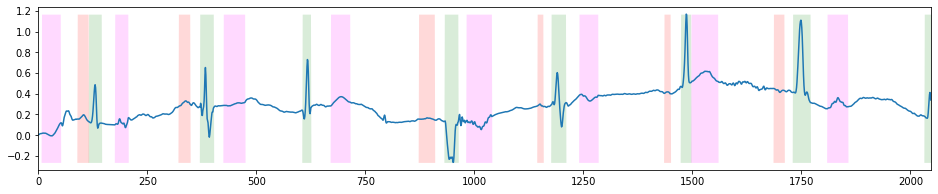

In [25]:
N = 2048
out = tmp[0]
if len(out) == 2:
    sig,masks_all = out
else:
    sig,masks_all,beats = out
    wtlist = [utils.wavelet.transform(beats[i],250.) for i in range(len(beats))]
sig = sig.squeeze()
# masks_all = mask.T

mskplt = ((np.max(sig)-np.min(sig))*masks_all)+np.min(sig)

plt.figure(figsize=(16,3))
plt.plot(sig)
plt.xlim([0,N])
plt.gca().fill_between(np.arange(N), mskplt[0,:], mskplt[0,:].min(), linewidth=0, alpha=0.15, color='red')
plt.gca().fill_between(np.arange(N), mskplt[1,:], mskplt[1,:].min(), linewidth=0, alpha=0.15, color='green')
plt.gca().fill_between(np.arange(N), mskplt[2,:], mskplt[2,:].min(), linewidth=0, alpha=0.15, color='magenta')
plt.show()

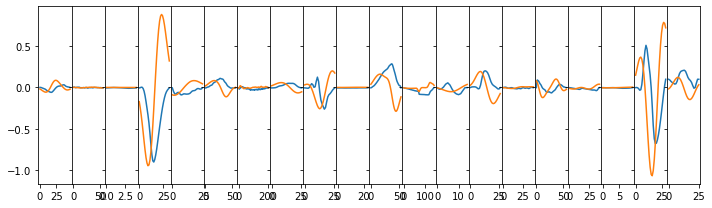

In [232]:
w = 0
s = 3
L = 20
f,ax = plt.subplots(ncols=L,figsize=(0.5*L,3),sharey=True)
[ax[i].plot(beats[w+i]) for i in range(L)]
[ax[i].plot(wtlist[w+i][:,0,s]) for i in range(L)]
f.tight_layout()
f.subplots_adjust(hspace=0.00,wspace=0.00)

In [ ]:
# pad_size = 64
# # i = 1000
# i = 0000
# # i = 14978
# # i = 14979
# s = 4
# sig = QRS[list(QRS)[i]]
# sig2 = np.pad(sig,((pad_size,pad_size),),mode='edge')
# wt = utils.wavelet.transform(sig2,250.).squeeze()
# print(wt.max(0)-wt.min(0))
# print(np.mean((wt.max(0)-wt.min(0))[-2:]))
# wt = wt[pad_size:-pad_size,:]
# plt.figure(figsize=(0.5,3))
# plt.plot(sig)
# plt.plot(wt[:,s])

In [ ]:
# s = 3
# sig2 = np.concatenate(beats)
# wt = utils.wavelet.transform(sig2,250)[:,0,s]
# wtlist = [utils.wavelet.transform(beats[i],250.) for i in range(len(beats))]
# wt2 = np.concatenate([wtlist[w][:,0,s] for w in range(len(wtlist))])

# f,ax = plt.subplots(nrows=4,figsize=(15,9))
# ax[0].plot(sig2)
# ax[1].plot(wt)
# ax[2].plot(wt2)
# ax[3].plot(wt2)
# ax[3].plot(wt)
# [ax[i].set_xlim([0,N]) for i in range(ax.size)]

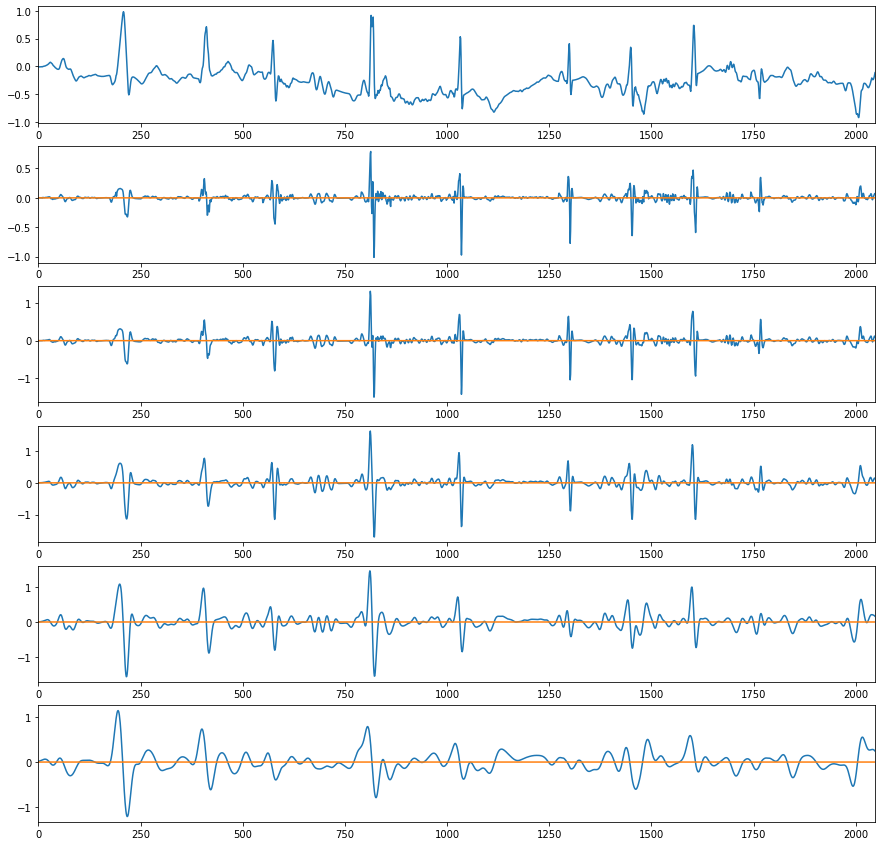

In [54]:
wt = utils.wavelet.transform(sig,250)
f,ax = utils.visualization.plot.wavelets(sig,wt,figsize=(15,15),returns=True)
[ax[i,0].set_xlim([0,N]) for i in range(6)]
plt.show()

# fiducials to delete

* QRS - 111_AVF_24
* QRS - sel820_1_156
* QRS - 95_AVR_16
* ~TP - sel306_1_211~
* ~TP - sel114_0_179~
* PT - sel803_0_109

# OLD AND CREEPY

#### Compute criteria

In [ ]:
# # Generate wavelets
# Pwavelet = {k: utils.wavelet.transform(Psignal[k],250.).squeeze() for k in tqdm.tqdm(Psignal.keys())}
# PQwavelet = {k: utils.wavelet.transform(PQsignal[k],250.).squeeze() for k in tqdm.tqdm(PQsignal.keys())}
# QRSwavelet = {k: utils.wavelet.transform(QRSsignal[k],250.).squeeze() for k in tqdm.tqdm(QRSsignal.keys())}
# STwavelet = {k: utils.wavelet.transform(STsignal[k],250.).squeeze() for k in tqdm.tqdm(STsignal.keys())}
# Twavelet = {k: utils.wavelet.transform(Tsignal[k],250.).squeeze() for k in tqdm.tqdm(Tsignal.keys())}
# TPwavelet = {k: utils.wavelet.transform(TPsignal[k],250.).squeeze() for k in tqdm.tqdm(TPsignal.keys())}

In [ ]:
# # Generate criteria
# s = 3 # wavelet scale
# eps = np.finfo('float').eps
# Pcriteria = {k: ((np.sign(Pwavelet[k][0,s]),(Pwavelet[k][0,s]-Pwavelet[k][1,s]+eps)/(np.max(Pwavelet[k][:,s])-np.min(Pwavelet[k][:,s]+eps))),
#                  (np.sign(Pwavelet[k][-1,s]),(Pwavelet[k][-1,s]-Pwavelet[k][-2,s]+eps)/(np.max(Pwavelet[k][:,s])-np.min(Pwavelet[k][:,s]+eps)))) for k in Psignal.keys()}
# PQcriteria = {k: ((np.sign(PQwavelet[k][0,s]),(PQwavelet[k][0,s]-PQwavelet[k][1,s]+eps)/(np.max(PQwavelet[k][:,s])-np.min(PQwavelet[k][:,s]+eps))),
#                  (np.sign(PQwavelet[k][-1,s]),(PQwavelet[k][-1,s]-PQwavelet[k][-2,s]+eps)/(np.max(PQwavelet[k][:,s])-np.min(PQwavelet[k][:,s]+eps)))) for k in PQsignal.keys()}
# QRScriteria = {k: ((np.sign(QRSwavelet[k][0,s]),(QRSwavelet[k][0,s]-QRSwavelet[k][1,s]+eps)/(np.max(QRSwavelet[k][:,s])-np.min(QRSwavelet[k][:,s]+eps))),
#                  (np.sign(QRSwavelet[k][-1,s]),(QRSwavelet[k][-1,s]-QRSwavelet[k][-2,s]+eps)/(np.max(QRSwavelet[k][:,s])-np.min(QRSwavelet[k][:,s]+eps)))) for k in QRSsignal.keys()}
# STcriteria = {k: ((np.sign(STwavelet[k][0,s]),(STwavelet[k][0,s]-STwavelet[k][1,s]+eps)/(np.max(STwavelet[k][:,s])-np.min(STwavelet[k][:,s]+eps))),
#                  (np.sign(STwavelet[k][-1,s]),(STwavelet[k][-1,s]-STwavelet[k][-2,s]+eps)/(np.max(STwavelet[k][:,s])-np.min(STwavelet[k][:,s]+eps)))) for k in STsignal.keys()}
# Tcriteria = {k: ((np.sign(Twavelet[k][0,s]),(Twavelet[k][0,s]-Twavelet[k][1,s]+eps)/(np.max(Twavelet[k][:,s])-np.min(Twavelet[k][:,s]+eps))),
#                  (np.sign(Twavelet[k][-1,s]),(Twavelet[k][-1,s]-Twavelet[k][-2,s]+eps)/(np.max(Twavelet[k][:,s])-np.min(Twavelet[k][:,s]+eps)))) for k in Tsignal.keys()}
# TPcriteria = {k: ((np.sign(TPwavelet[k][0,s]),(TPwavelet[k][0,s]-TPwavelet[k][1,s]+eps)/(np.max(TPwavelet[k][:,s])-np.min(TPwavelet[k][:,s]+eps))),
#                  (np.sign(TPwavelet[k][-1,s]),(TPwavelet[k][-1,s]-TPwavelet[k][-2,s]+eps)/(np.max(TPwavelet[k][:,s])-np.min(TPwavelet[k][:,s]+eps)))) for k in TPsignal.keys()}

In [ ]:
# N = 2048
# s = 3

# has_P = np.random.rand(1) > 0.1
# has_PQ = np.random.rand(1) > 0.2
# has_ST = np.random.rand(1) > 0.2
# has_BBB = np.random.rand(1) > 0.9
# counter_BBB = 0
# repetitions_BBB = np.random.randint(2,4)

# beats = []
# ids = []

# # Include first beat
# ids.append(('TPsignal',np.random.randint(0,len(TPsignal))))
# beats.append(utils.signal.on_off_correction(TPsignal[list(TPsignal)[ids[-1][1]]]))
# size = beats[0].size
# masks = np.zeros((size,),dtype='int8')
# onset = np.random.randint(0,size)
# while size-onset < N:
#     # P wave (sometimes)
#     if has_BBB:
#         if counter_BBB == 0:
#             id_BBB_P = ('Psignal',np.random.randint(0,len(Psignal)))
#         ids.append(id_BBB_P)
#         p = trailonset(Psignal[list(Psignal)[ids[-1][1]]],beats[-1][-1])[1:]
#         beats.append(p)
#         masks = np.concatenate((masks,1*np.ones((p.size,),dtype='int8')))

#         if has_PQ:
#             # PQ segment
#             ids.append(('PQsignal',np.random.randint(0,len(PQsignal))))
#             pq = trailonset(PQsignal[list(PQsignal)[ids[-1][1]]],beats[-1][-1])[1:]
#             beats.append(pq)
#             masks = np.concatenate((masks,np.zeros((pq.size,),dtype='int8')))
#     elif (np.random.rand(1) < 0.75) and (has_P):
#         ids.append(('Psignal',np.random.randint(0,len(Psignal))))
#         p = trailonset(Psignal[list(Psignal)[ids[-1][1]]],beats[-1][-1])[1:]
#         beats.append(p)
#         masks = np.concatenate((masks,1*np.ones((p.size,),dtype='int8')))

#         if has_PQ:
#             # PQ segment
#             ids.append(('PQsignal',np.random.randint(0,len(PQsignal))))
#             pq = trailonset(PQsignal[list(PQsignal)[ids[-1][1]]],beats[-1][-1])[1:]
#             beats.append(pq)
#             masks = np.concatenate((masks,np.zeros((pq.size,),dtype='int8')))

#     # QRS wave
#     has_QRS = np.random.rand(1)
#     if has_BBB:
#         if counter_BBB%repetitions_BBB == 0:
#             id_BBB_QRS = ('QRSsignal',np.random.randint(0,len(QRSsignal)))
#             ids.append(id_BBB_QRS)
#             qrs = trailonset(QRSsignal[list(QRSsignal)[ids[-1][1]]],beats[-1][-1])[1:]
#             beats.append(qrs)
#             masks = np.concatenate((masks,2*np.ones((qrs.size,),dtype='int8')))
#         else:
#             pass
#     elif (has_QRS < 0.99):
#         ids.append(('QRSsignal',np.random.randint(0,len(QRSsignal))))
#         qrs = trailonset(QRSsignal[list(QRSsignal)[ids[-1][1]]],beats[-1][-1])[1:]
#         beats.append(qrs)
#         masks = np.concatenate((masks,2*np.ones((qrs.size,),dtype='int8')))
    
#     # ST segment
#     if has_BBB and (counter_BBB%repetitions_BBB != 0):
#         pass
#     elif (np.random.rand(1) < 0.75) and (has_ST):
#         ids.append(('STsignal',np.random.randint(0,len(STsignal))))
#         st = trailonset(STsignal[list(STsignal)[ids[-1][1]]],beats[-1][-1])[1:]
#         beats.append(st)
#         masks = np.concatenate((masks,np.zeros((st.size,),dtype='int8')))

#     # T wave
#     if has_BBB:
#         if counter_BBB%repetitions_BBB == 0:
#             ids.append(('Tsignal',np.random.randint(0,len(Tsignal))))
#             t = trailonset(Tsignal[list(Tsignal)[ids[-1][1]]],beats[-1][-1])[1:]
#             beats.append(t)
#             masks = np.concatenate((masks,3*np.ones((t.size,),dtype='int8')))
#         else:
#             pass
#     elif (has_QRS < 0.99):
#         ids.append(('Tsignal',np.random.randint(0,len(Tsignal))))
#         t = trailonset(Tsignal[list(Tsignal)[ids[-1][1]]],beats[-1][-1])[1:]
#         beats.append(t)
#         masks = np.concatenate((masks,3*np.ones((t.size,),dtype='int8')))

#     # TP segment
#     if has_BBB:
#         if counter_BBB == 0:
#             id_BBB_TP = ('TPsignal',np.random.randint(0,len(TPsignal)))
#         ids.append(id_BBB_TP)
#         tp = trailonset(TPsignal[list(TPsignal)[ids[-1][1]]],beats[-1][-1])[1:]
#         beats.append(tp)
#         masks = np.concatenate((masks,np.zeros((tp.size,),dtype='int8')))
#     else:
#         ids.append(('TPsignal',np.random.randint(0,len(TPsignal))))
#         tp = trailonset(TPsignal[list(TPsignal)[ids[-1][1]]],beats[-1][-1])[1:]
#         beats.append(tp)
#         masks = np.concatenate((masks,np.zeros((tp.size,),dtype='int8')))
    
#     # Account for total signal size
#     size = sum([beats[i].size for i in range(len(beats))])
        
#     # Update BBB counter
#     if has_BBB:
#         counter_BBB += 1

# sig = np.concatenate(beats)[onset:onset+2048]
# # sig = sp.signal.filtfilt(*sp.signal.butter(4,   0.5/250, 'high'),sig)
# signal = sig# + np.convolve(np.cumsum(norm.rvs(scale=0.15**(2*0.5),size=N)),np.hamming(w)/(w/2),mode='same')

# masks = masks[onset:onset+2048]
# masks_all = np.zeros((N,3),dtype=bool)
# masks_all[:,0] = masks == 1
# masks_all[:,1] = masks == 2
# masks_all[:,2] = masks == 3
# mskplt = ((np.max(signal)-np.min(signal))*masks_all)+np.min(signal)

# # f,ax = plt.subplots(nrows=1,figsize=(20,4))
# # ax = np.array(ax)
# # if len(ax.shape) == 0: ax = ax[None]
# # [ax[i].set_xlim([0,N]) for i in range(ax.size)]
# # [ax[i].fill_between(np.arange(N), mskplt[:,0], mskplt[:,0].min(), linewidth=0, alpha=0.15, color='red') for i in range(ax.size)]
# # [ax[i].fill_between(np.arange(N), mskplt[:,1], mskplt[:,1].min(), linewidth=0, alpha=0.15, color='green') for i in range(ax.size)]
# # [ax[i].fill_between(np.arange(N), mskplt[:,2], mskplt[:,2].min(), linewidth=0, alpha=0.15, color='magenta') for i in range(ax.size)]
# # ax[0].plot(signal)
# # # ax[1].plot(wvlts,color='orange')
# # # ax[2].plot(wvlts_signal,color='orange')

In [ ]:
# N = 2048

# beats = []
# ids = []

# # Include first beat
# ids.append(('TPsignal',np.random.randint(0,len(TPsignal))))
# beats.append(utils.signal.on_off_correction(TPsignal[list(TPsignal)[ids[-1][1]]]))
# # beats.append(TPsignal[list(TPsignal)[np.random.randint(0,len(TPsignal))]])
# size = beats[0].size
# masks = np.zeros((size,))
# onset = np.random.randint(0,size)
# while size-onset < N:
#     # P wave (sometimes)
#     if np.random.rand(1) < 0.75:
#         # p = utils.signal.on_off_correction(Psignal[list(Psignal)[np.random.randint(0,len(Psignal))]])
#         ids.append(('Psignal',np.random.randint(0,len(Psignal))))
#         p = trailonset(Psignal[list(Psignal)[ids[-1][1]]],beats[-1][-1])
#         # p = Psignal[list(Psignal)[np.random.randint(0,len(Psignal))]]
#         beats.append(p)
#         masks = np.concatenate((masks,1*np.ones((p.size,))))

#     # PQ segment
#     # pq = utils.signal.on_off_correction(PQsignal[list(PQsignal)[np.random.randint(0,len(PQsignal))]])
#     ids.append(('PQsignal',np.random.randint(0,len(PQsignal))))
#     pq = trailonset(PQsignal[list(PQsignal)[ids[-1][1]]],beats[-1][-1])
#     # pq = PQsignal[list(PQsignal)[np.random.randint(0,len(PQsignal))]]
#     beats.append(pq)
#     masks = np.concatenate((masks,np.zeros((pq.size,))))

#     # QRS wave
#     # qrs = utils.signal.on_off_correction(QRSsignal[list(QRSsignal)[np.random.randint(0,len(QRSsignal))]])
#     ids.append(('QRSsignal',np.random.randint(0,len(QRSsignal))))
#     qrs = trailonset(QRSsignal[list(QRSsignal)[ids[-1][1]]],beats[-1][-1])
#     # qrs = QRSsignal[list(QRSsignal)[np.random.randint(0,len(QRSsignal))]]
#     beats.append(qrs)
#     masks = np.concatenate((masks,2*np.ones((qrs.size,))))

#     # ST segment
#     # st = utils.signal.on_off_correction(STsignal[list(STsignal)[np.random.randint(0,len(STsignal))]])
#     ids.append(('STsignal',np.random.randint(0,len(STsignal))))
#     st = trailonset(STsignal[list(STsignal)[ids[-1][1]]],beats[-1][-1])
#     # st = STsignal[list(STsignal)[np.random.randint(0,len(STsignal))]]
#     beats.append(st)
#     masks = np.concatenate((masks,np.zeros((st.size,))))

#     # T wave
#     # t = utils.signal.on_off_correction(Tsignal[list(Tsignal)[np.random.randint(0,len(Tsignal))]])
#     ids.append(('Tsignal',np.random.randint(0,len(Tsignal))))
#     t = trailonset(Tsignal[list(Tsignal)[ids[-1][1]]],beats[-1][-1])
#     # t = Tsignal[list(Tsignal)[np.random.randint(0,len(Tsignal))]]
#     beats.append(t)
#     masks = np.concatenate((masks,3*np.ones((t.size,))))

#     # TP segment
#     # tp = utils.signal.on_off_correction(TPsignal[list(TPsignal)[np.random.randint(0,len(TPsignal))]])
#     ids.append(('TPsignal',np.random.randint(0,len(TPsignal))))
#     tp = trailonset(TPsignal[list(TPsignal)[ids[-1][1]]],beats[-1][-1])
#     # tp = TPsignal[list(TPsignal)[np.random.randint(0,len(TPsignal))]]
#     beats.append(tp)
#     masks = np.concatenate((masks,np.zeros((tp.size,))))

#     size = sum([beats[i].size for i in range(len(beats))])

# w = 51
# sig = np.concatenate(beats)[onset:onset+2048]
# sig = sp.signal.filtfilt(*sp.signal.butter(4,   0.5/250, 'high'),sig)
# signal = sig# + np.convolve(np.cumsum(norm.rvs(scale=0.15**(2*0.5),size=N)),np.hamming(w)/(w/2),mode='same')

# masks = masks[onset:onset+2048]
# masks_all = np.zeros((N,3),dtype=bool)
# masks_all[:,0] = masks == 1
# masks_all[:,1] = masks == 2
# masks_all[:,2] = masks == 3
# mskplt = ((np.max(signal)-np.min(signal))*masks_all)+np.min(signal)

# plt.figure(figsize=(20,5))
# plt.plot(signal)
# plt.gca().fill_between(np.arange(N), mskplt[:,0], mskplt[:,0].min(), linewidth=0, alpha=0.15, color='red')
# plt.gca().fill_between(np.arange(N), mskplt[:,1], mskplt[:,1].min(), linewidth=0, alpha=0.15, color='green')
# plt.gca().fill_between(np.arange(N), mskplt[:,2], mskplt[:,2].min(), linewidth=0, alpha=0.15, color='magenta')
# plt.show()